In [4]:
import pandas as pd
from datetime import datetime
import plotly.express as px
import matplotlib.pyplot as plt
import numpy as np
import math
from math import sqrt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM, SimpleRNN, GRU

B02512
Train Score: 13.40 RMSE
Test Score: 15.73 RMSE


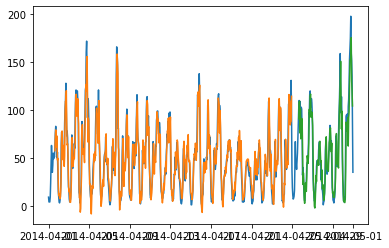

B02598
Train Score: 50.63 RMSE
Test Score: 91.30 RMSE


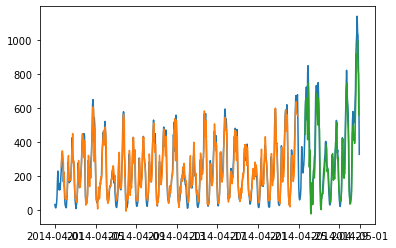

B02617
Train Score: 40.19 RMSE
Test Score: 52.14 RMSE


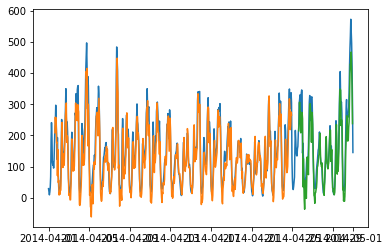

B02682
Train Score: 68.00 RMSE
Test Score: 79.50 RMSE


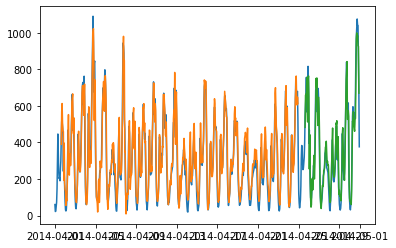

B02764
Train Score: 5.17 RMSE
Test Score: 6.00 RMSE


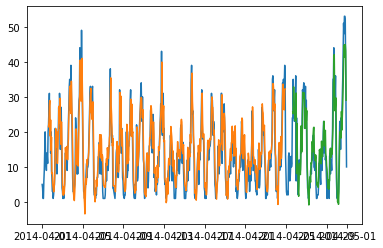

In [5]:
uber_apr14 = pd.read_csv('uber-tlc-foil-response-master/uber-trip-data/uber-raw-data-apr14.csv')

uber_apr14['Date/Time'] = pd.to_datetime(uber_apr14['Date/Time'])

df_by_base = uber_apr14.groupby([pd.Grouper(key='Date/Time',freq='H'),uber_apr14.Base]).size().reset_index(name='count')

def create_dataset(dataset, look_back=15):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

df_b02512 = df_by_base[df_by_base['Base']=='B02512'].drop(axis=0, columns='Base')
df_b02598 = df_by_base[df_by_base['Base']=='B02598'].drop(axis=0, columns='Base')
df_b02617 = df_by_base[df_by_base['Base']=='B02617'].drop(axis=0, columns='Base')
df_b02682 = df_by_base[df_by_base['Base']=='B02682'].drop(axis=0, columns='Base')
df_b02764 = df_by_base[df_by_base['Base']=='B02764'].drop(axis=0, columns='Base')

for df, base in zip([df_b02512, df_b02598, df_b02617, df_b02682, df_b02764],['B02512', 'B02598', 'B02617', 'B02682', 'B02764']):
    
    df_for_graph = df.reset_index(drop=True)
    
    print(base)
    
    min_max_scaler = MinMaxScaler(feature_range=(0, 1))
    df = min_max_scaler.fit_transform(df['count'].values.reshape(-1, 1))

    train_size = int(len(df) * 0.8)
    test_size = len(df) - train_size
    train, test = df[0:train_size], df[train_size:len(df)]

    x_train, y_train = create_dataset(train, look_back=15)
    x_test, y_test = create_dataset(test, look_back=15)

    x_train = np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1]))
    x_test = np.reshape(x_test, (x_test.shape[0], 1, x_test.shape[1]))
    
    look_back = 15
    model = Sequential()
    model.add(Dense(20, input_shape=(1, look_back)))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(x_train, y_train, epochs=20, batch_size=1, verbose=0)

    trainPredict = np.squeeze(model.predict(x_train), axis=(2,))
    testPredict = np.squeeze(model.predict(x_test), axis=(2,))
    
    # invert predictions
    trainPredict = min_max_scaler.inverse_transform(trainPredict)
    trainY = min_max_scaler.inverse_transform([y_train])
    testPredict = min_max_scaler.inverse_transform(testPredict)
    testY = min_max_scaler.inverse_transform([y_test])

    # calculate root mean squared error
    trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
    print('Train Score: %.2f RMSE' % (trainScore))
    testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
    print('Test Score: %.2f RMSE' % (testScore))

    # shift train predictions for plotting
    trainPredictPlot = np.empty_like(df)
    trainPredictPlot[:, :] = np.nan
    trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

    # shift test predictions for plotting
    testPredictPlot = np.empty_like(df)
    testPredictPlot[:, :] = np.nan
    testPredictPlot[len(trainPredict)+(look_back*2)+1:len(df)-1, :] = testPredict

    # plot baseline and predictions

    df_for_graph['trainPredictPlot'] = trainPredictPlot
    df_for_graph['testPredictPlot'] = testPredictPlot

    plt.plot('Date/Time', 'count', data=df_for_graph)
    plt.plot('Date/Time', 'trainPredictPlot', data=df_for_graph)
    plt.plot('Date/Time', 'testPredictPlot', data=df_for_graph)
    plt.show()